In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pdb
from tqdm import tqdm

## assumptions

1. sediment concentration uniform in x, one grain begins at each x-index location at height of bedload
2. particle velocity influenced by water velocity, gravity, and viscosity


83


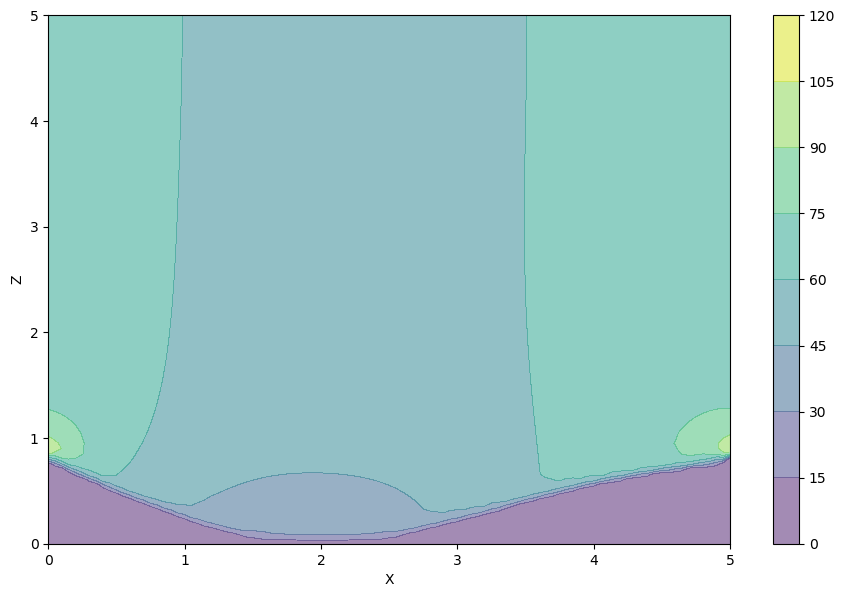

In [2]:
#CFD laminar flow field

def build_up_b(rho, dt, dx, dy, u, v):
    b = np.zeros_like(u)
    b[1:-1, 1:-1] = (rho * (1 / dt * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx) +
                                      (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                            ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                            2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                                 (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                            ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
    
    # Periodic BC Pressure @ x = 2
    b[1:-1, -1] = (rho * (1 / dt * ((u[1:-1, 0] - u[1:-1,-2]) / (2 * dx) +
                                    (v[2:, -1] - v[0:-2, -1]) / (2 * dy)) -
                          ((u[1:-1, 0] - u[1:-1, -2]) / (2 * dx))**2 -
                          2 * ((u[2:, -1] - u[0:-2, -1]) / (2 * dy) *
                               (v[1:-1, 0] - v[1:-1, -2]) / (2 * dx)) -
                          ((v[2:, -1] - v[0:-2, -1]) / (2 * dy))**2))

    # Periodic BC Pressure @ x = 0
    b[1:-1, 0] = (rho * (1 / dt * ((u[1:-1, 1] - u[1:-1, -1]) / (2 * dx) +
                                   (v[2:, 0] - v[0:-2, 0]) / (2 * dy)) -
                         ((u[1:-1, 1] - u[1:-1, -1]) / (2 * dx))**2 -
                         2 * ((u[2:, 0] - u[0:-2, 0]) / (2 * dy) *
                              (v[1:-1, 1] - v[1:-1, -1]) / (2 * dx))-
                         ((v[2:, 0] - v[0:-2, 0]) / (2 * dy))**2))
    
    return b

def pressure_poisson_periodic(p, dx, dy):
    pn = np.empty_like(p)
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 +
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                         (2 * (dx**2 + dy**2)) -
                         dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, 1:-1])

        # Periodic BC Pressure @ x = 2
        p[1:-1, -1] = (((pn[1:-1, 0] + pn[1:-1, -2])* dy**2 +
                        (pn[2:, -1] + pn[0:-2, -1]) * dx**2) /
                       (2 * (dx**2 + dy**2)) -
                       dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, -1])

        # Periodic BC Pressure @ x = 0
        p[1:-1, 0] = (((pn[1:-1, 1] + pn[1:-1, -1])* dy**2 +
                       (pn[2:, 0] + pn[0:-2, 0]) * dx**2) /
                      (2 * (dx**2 + dy**2)) -
                      dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, 0])
        
        # Wall boundary conditions, pressure
        p[-1, :] =p[-2, :]  # dp/dy = 0 at y = 2
        p[0, :] = p[1, :]  # dp/dy = 0 at y = 0
    
    return p

##variable declarations
nx = 101
ny = 101
nt = 10
nit = 50 
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 5, nx)
y = np.linspace(0, 5, ny)
X, Y = np.meshgrid(x, y)


##physical variables
rho = 1000
nu = 4
F = 1
dt = .000001

#initial conditions
u = np.zeros((ny, nx)) + 60
un = np.zeros((ny, nx))

v = np.zeros((ny, nx))
vn = np.zeros((ny, nx))

p = np.ones((ny, nx))
pn = np.ones((ny, nx))

b = np.zeros((ny, nx))

# Define scallop surface
def scallop_array(x_array, number_of_scallops):
    
    y = np.ones(x_array.shape)
    T = np.int_((len(x_array) - 1) / number_of_scallops)
   
    one_period = np.linspace(0, 1, T + 1) #x-array for a single scallop
    period = len(one_period)-1
    n = number_of_scallops 
           
    for i in range(n):
        for j in range(period):
            v =1 -((0.112 * np.sin(np.pi * one_period)) + (0.028 * np.sin(2 * np.pi * one_period)) - (0.004 * np.sin(3 * np.pi * one_period)))
            y[i*period + j] = v[j]    
        y = y*5 - 4.37
   
    return y

numsc = 1
w = scallop_array(x, numsc)

udiff = 1
stepcount = 0

while udiff > 0.00001:
    un = u.copy()
    vn = v.copy()

    b = build_up_b(rho, dt, dx, dy, u, v)
    p = pressure_poisson_periodic(p, dx, dy)

    u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * 
                    (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                     vn[1:-1, 1:-1] * dt / dy * 
                    (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                     dt / (2 * rho * dx) * 
                    (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                     nu * (dt / dx**2 * 
                    (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                     dt / dy**2 * 
                    (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])) + 
                     F * dt)

    v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * 
                    (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                     vn[1:-1, 1:-1] * dt / dy * 
                    (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                     dt / (2 * rho * dy) * 
                    (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                     nu * (dt / dx**2 *
                    (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                     dt / dy**2 * 
                    (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

    # Periodic BC u @ x = -1     
    u[1:-1, -1] = (un[1:-1, -1] - un[1:-1, -1] * dt / dx * 
                  (un[1:-1, -1] - un[1:-1, -2]) -
                   vn[1:-1, -1] * dt / dy * 
                  (un[1:-1, -1] - un[0:-2, -1]) -
                   dt / (2 * rho * dx) *
                  (p[1:-1, 0] - p[1:-1, -2]) + 
                   nu * (dt / dx**2 * 
                  (un[1:-1, 0] - 2 * un[1:-1,-1] + un[1:-1, -2]) +
                   dt / dy**2 * 
                  (un[2:, -1] - 2 * un[1:-1, -1] + un[0:-2, -1])) + F * dt)

    # Periodic BC u @ x = 0
    u[1:-1, 0] = (un[1:-1, 0] - un[1:-1, 0] * dt / dx *
                 (un[1:-1, 0] - un[1:-1, -1]) -
                  vn[1:-1, 0] * dt / dy * 
                 (un[1:-1, 0] - un[0:-2, 0]) - 
                  dt / (2 * rho * dx) * 
                 (p[1:-1, 1] - p[1:-1, -1]) + 
                  nu * (dt / dx**2 * 
                 (un[1:-1, 1] - 2 * un[1:-1, 0] + un[1:-1, -1]) +
                  dt / dy**2 *
                 (un[2:, 0] - 2 * un[1:-1, 0] + un[0:-2, 0])) + F * dt)

    # Periodic BC v @ x = -1
    v[1:-1, -1] = (vn[1:-1, -1] - un[1:-1, -1] * dt / dx *
                  (vn[1:-1, -1] - vn[1:-1, -2]) - 
                   vn[1:-1, -1] * dt / dy *
                  (vn[1:-1, -1] - vn[0:-2, -1]) -
                   dt / (2 * rho * dy) * 
                  (p[2:, -1] - p[0:-2, -1]) +
                   nu * (dt / dx**2 *
                  (vn[1:-1, 0] - 2 * vn[1:-1, -1] + vn[1:-1, -2]) +
                   dt / dy**2 *
                  (vn[2:, -1] - 2 * vn[1:-1, -1] + vn[0:-2, -1])))

    # Periodic BC v @ x = 0
    v[1:-1, 0] = (vn[1:-1, 0] - un[1:-1, 0] * dt / dx *
                 (vn[1:-1, 0] - vn[1:-1, -1]) -
                  vn[1:-1, 0] * dt / dy *
                 (vn[1:-1, 0] - vn[0:-2, 0]) -
                  dt / (2 * rho * dy) * 
                 (p[2:, 0] - p[0:-2, 0]) +
                  nu * (dt / dx**2 * 
                 (vn[1:-1, 1] - 2 * vn[1:-1, 0] + vn[1:-1, -1]) +
                  dt / dy**2 * 
                 (vn[2:, 0] - 2 * vn[1:-1, 0] + vn[0:-2, 0])))
    
    
    # Wall BC: no-slip on scallop surface
    u[:16, 0] = 0
    u[:15, 1] = 0
    u[:15, 2] = 0
    u[:14, 3] = 0
    u[:13, 4] = 0
    u[:13, 5] = 0
    u[:12, 6] = 0
    u[:12, 7] = 0
    u[:11, 8] = 0
    u[:10, 9] = 0
    u[:10, 10] = 0
    u[:9, 11] = 0
    u[:9, 12] = 0
    u[:8, 13] = 0
    u[:8, 14] = 0
    u[:7, 15] = 0
    u[:7, 16] = 0
    u[:6, 17] = 0
    u[:6, 18] = 0
    u[:5, 19] = 0
    u[:5, 20] = 0
    u[:4, 21] = 0
    u[:4, 22] = 0
    u[:3, 23] = 0
    u[:3, 24] = 0
    u[:3, 25] = 0
    u[:2, 26] = 0
    u[:2, 27] = 0
    u[:2, 28] = 0
    u[:1, 29] = 0
    u[:1, 30] = 0
    u[:1, 31] = 0
    u[:1, 32] = 0
    u[:1, 33] = 0
    u[0, 34] = 0
    u[0, 35] = 0
    u[0, 36] = 0
    u[0, 37] = 0
    u[0, 38] = 0
    u[0, 39] = 0
    u[0, 40] = 0
    u[0, 41] = 0
    u[0, 42] = 0
    u[0, 43] = 0
    u[0, 44] = 0
    u[0, 45] = 0
    u[:1, 46] = 0
    u[:1, 47] = 0
    u[:1, 48] = 0
    u[:1, 49] = 0
    u[:1, 50] = 0
    u[:1, 51] = 0
    u[:2, 52] = 0
    u[:2, 53] = 0
    u[:2, 54] = 0
    u[:3, 55] = 0
    u[:3, 56] = 0
    u[:3, 57] = 0
    u[:4, 58] = 0
    u[:4, 59] = 0
    u[:4, 60] = 0
    u[:5, 61] = 0
    u[:5, 62] = 0
    u[:5, 63] = 0
    u[:6, 64] = 0
    u[:6, 65] = 0
    u[:6, 66] = 0
    u[:7, 67] = 0
    u[:7, 68] = 0
    u[:8, 69] = 0
    u[:8, 70] = 0
    u[:8, 71] = 0
    u[:9, 72] = 0
    u[:9, 73] = 0
    u[:9, 74] = 0
    u[:10, 75] = 0
    u[:10, 76] = 0
    u[:10, 77] = 0
    u[:11, 78] = 0
    u[:11, 79] = 0
    u[:11, 80] = 0
    u[:12, 81] = 0
    u[:12, 82] = 0
    u[:12, 83] = 0
    u[:12, 84] = 0
    u[:13, 85] = 0
    u[:13, 86] = 0
    u[:13, 87] = 0
    u[:13, 88] = 0
    u[:14, 89] = 0
    u[:14, 90] = 0
    u[:14, 91] = 0
    u[:14, 92] = 0
    u[:14, 93] = 0
    u[:15, 94] = 0
    u[:15, 95] = 0
    u[:15, 96] = 0
    u[:15, 97] = 0
    u[:15, 98] = 0
    u[:16, 99] = 0
    u[:17, 100] = 0
    v[:16, 0] = 0
    v[:15, 1] = 0
    v[:15, 2] = 0
    v[:14, 3] = 0
    v[:13, 4] = 0
    v[:13, 5] = 0
    v[:12, 6] = 0
    v[:12, 7] = 0
    v[:11, 8] = 0
    v[:10, 9] = 0
    v[:10, 10] = 0
    v[:9, 11] = 0
    v[:9, 12] = 0
    v[:8, 13] = 0
    v[:8, 14] = 0
    v[:7, 15] = 0
    v[:7, 16] = 0
    v[:6, 17] = 0
    v[:6, 18] = 0
    v[:5, 19] = 0
    v[:5, 20] = 0
    v[:4, 21] = 0
    v[:4, 22] = 0
    v[:3, 23] = 0
    v[:3, 24] = 0
    v[:3, 25] = 0
    v[:2, 26] = 0
    v[:2, 27] = 0
    v[:2, 28] = 0
    v[:1, 29] = 0
    v[:1, 30] = 0
    v[:1, 31] = 0
    v[:1, 32] = 0
    v[:1, 33] = 0
    v[0, 34] = 0
    v[0, 35] = 0
    v[0, 36] = 0
    v[0, 37] = 0
    v[0, 38] = 0
    v[0, 39] = 0
    v[0, 40] = 0
    v[0, 41] = 0
    v[0, 42] = 0
    v[0, 43] = 0
    v[0, 44] = 0
    v[0, 45] = 0
    v[:1, 46] = 0
    v[:1, 47] = 0
    v[:1, 48] = 0
    v[:1, 49] = 0
    v[:1, 50] = 0
    v[:1, 51] = 0
    v[:2, 52] = 0
    v[:2, 53] = 0
    v[:2, 54] = 0
    v[:3, 55] = 0
    v[:3, 56] = 0
    v[:3, 57] = 0
    v[:4, 58] = 0
    v[:4, 59] = 0
    v[:4, 60] = 0
    v[:5, 61] = 0
    v[:5, 62] = 0
    v[:5, 63] = 0
    v[:6, 64] = 0
    v[:6, 65] = 0
    v[:6, 66] = 0
    v[:7, 67] = 0
    v[:7, 68] = 0
    v[:8, 69] = 0
    v[:8, 70] = 0
    v[:8, 71] = 0
    v[:9, 72] = 0
    v[:9, 73] = 0
    v[:9, 74] = 0
    v[:10, 75] = 0
    v[:10, 76] = 0
    v[:10, 77] = 0
    v[:11, 78] = 0
    v[:11, 79] = 0
    v[:11, 80] = 0
    v[:12, 81] = 0
    v[:12, 82] = 0
    v[:12, 83] = 0
    v[:12, 84] = 0
    v[:13, 85] = 0
    v[:13, 86] = 0
    v[:13, 87] = 0
    v[:13, 88] = 0
    v[:14, 89] = 0
    v[:14, 90] = 0
    v[:14, 91] = 0
    v[:14, 92] = 0
    v[:14, 93] = 0
    v[:15, 94] = 0
    v[:15, 95] = 0
    v[:15, 96] = 0
    v[:15, 97] = 0
    v[:15, 98] = 0
    v[:16, 99] = 0
    v[:17, 100] = 0
    
    #water surface BC, du/dy = 0 @ y = -1, v = 0 @ y = -2
    u[-1, :] = u[-2, :] 
    v[-1, :]=0
    
    udiff = np.abs(np.sum(u) - np.sum(un)) / np.sum(u)
    stepcount += 1


    
print(stepcount)

fig = plt.figure(figsize=(11, 7), dpi=100)
plt.ylim(0,5)
#plt.quiver(X[::, ::], Y[::, ::], u[::, ::], v[::, ::]);
plt.contourf(X, Y, np.sqrt(u**2 + v**2), alpha = 0.5)
plt.colorbar()
#plt.contour(X, Y, u)
#plt.plot(x , w, 'b')
#plt.title('Velocity magnitude (cm/s) with streamlines')
#plt.streamplot(X, Y, u, v)
plt.xlabel('X')
plt.ylabel('Z');


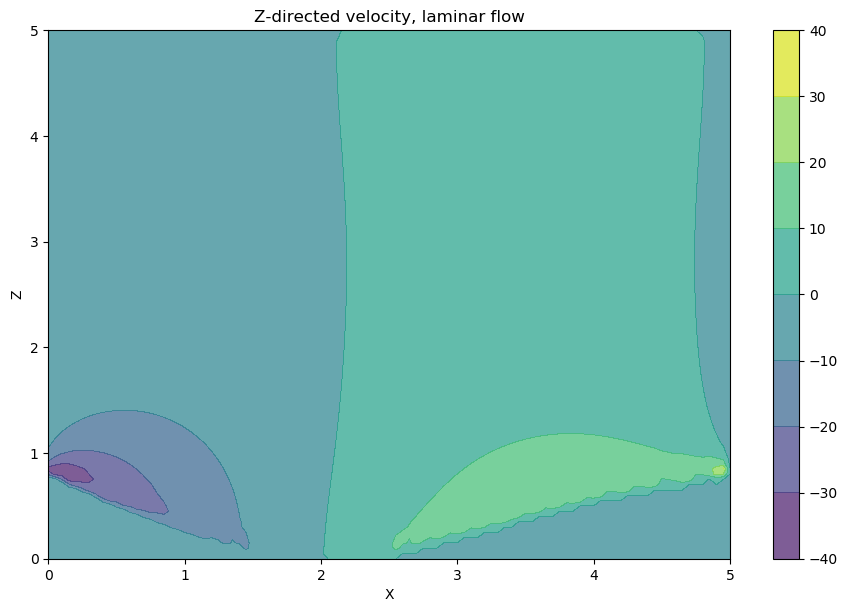

In [3]:
fig = plt.figure(figsize=(11, 7), dpi=100)
#plt.plot(x0[:101], z0[:101])
plt.contourf(X, Y, v, alpha = 0.7, vmin = -40, vmax = 40)
plt.colorbar()
plt.title('Z-directed velocity, laminar flow')
plt.xlabel('X')
plt.ylabel('Z');

In [4]:
# six-scallop long velocity matrix

u_water = np.empty(shape=(101,601))
w_water = np.empty(shape=(101,601))

a = 6
b = len(u) - 1
c = len(u) - 1

for i in range(a):
    for j in range(b):   
        u_water[:, i*b + j] = u[:, j]
        w_water[:, i*b + j] = v[:, j]
        

In [5]:
# building the initial scallop array

xmax = 6  #number of scallops
dx = 0.01
xScal = np.arange(0, xmax+dx,dx)  #x-array for scallop field
uScal = np.arange(0,1+dx,dx)  #x-array for a single scallop

def scallop_array(x_array, one_period, number_of_scallops):
    
    z = np.zeros(x_array.shape)
    period = len(one_period)-1
    n = number_of_scallops 
           
    for i in range(n):
        for j in range(period):
            v =-((0.112 * np.sin(np.pi * one_period)) + (0.028 * np.sin(2 * np.pi * one_period)) - (0.004 * np.sin(3 * np.pi * one_period)))    #(Blumberg and Curl, 1974)
            z[i*period + j] = v[j]
    
    x = (x_array/number_of_scallops) * 30
    z = 0.7 + z*5

    return x, z

x0, z0 = scallop_array(xScal, uScal, xmax)   #initial scallop profile, dimensions in centimeters
dzdx = np.gradient(z0, x0)
theta2 = np.arctan(dzdx)  #slope angle at each point along scalloped profile

In [6]:
# definitions and parameters

Hf_gravel = 7.92    #distance of fall for 60-mm gravel (Lamb et al., 2008)
Hf_sand = 3.84     #distance of fall for 1-mm sand (Lamb et al., 2008)
D_gravel = 6
D_sand = 0.1
rho_quartz = 2.65  # g*cm^-3
rho_water = 1
Re = 23300     #Reynold's number from scallop formation experiments (Blumberg and Curl, 1974)
drag_coef = (-490.546/Re) + (57.87e4/(Re*Re)) + 0.46
mu_water = 0.013  # g*cm^-1*s^-1
L = 5    # cm, Sauter-mean crest-to-crest scallop length

Hf_grain = 6
D_grain = 4.5



In [7]:
def settling_velocity(rho_sediment, rho_fluid, drag_coef, grain_size, fall_distance):
    R = (rho_sediment/rho_fluid - 1)
    g = 981 # cm*s^-2
    D = grain_size
    C = drag_coef
    H = fall_distance
    w_s = -(np.sqrt((4*R*g*D)/(3*C))) 
    
    return w_s

In [8]:
u_w0 = (Re * mu_water) / (L * rho_water)   # cm/s, assume constant downstream, x-directed velocity equal to average velocity of water as in Curl (1974)

w_s_gravel = settling_velocity(rho_quartz, rho_water, drag_coef, D_gravel, Hf_gravel)
mass_gravel = np.pi * rho_quartz * D_gravel**3 / 6
w_s_sand = settling_velocity(rho_quartz, rho_water, drag_coef, D_sand, Hf_sand)
mass_sand = np.pi * rho_quartz * D_sand**3 / 6

mass_grain = np.pi * rho_quartz * D_grain**3 / 6
w_s_grain = settling_velocity(rho_quartz, rho_water, drag_coef, D_grain, Hf_grain)


In [9]:
dx = 0.05
dt = dx / u_w0
print(dt)
w_s = w_s_gravel
Hf = Hf_gravel
l_ds = (3 * Hf * u_w0) / (2 * w_s)
print(l_ds)

0.0008253549026081215
-4.195239317969238


In [30]:
def sediment_saltation(x0, scallop_elevation, Hf, w_water, u_water, u_w0, w_s, D, dx, theta2, drag_coef):
    
    ### define constants and parameters
    rho_w = 1
    rho_s = 2.65
    drag = (3 * rho_w/(rho_w + 2 * rho_s))  ##### velocity factor for sphere transported by fluid (Landau and Lifshitz, 1995)
    g = -981
    l_ds = -(3 * Hf * u_w0) / (2 * w_s)  # length of saltation hop for trajectory calculation above CFD flow field (Lamb et al., 2008)
    m = np.pi * rho_s * D**3 / 6
    
    impact_data = np.zeros(shape=(len(x0), 7))  # 0 = time, 1 = x, 2 = z, 3 = u, 4 = w, 5 = |Vel|, 6 = KE; one row per particle
    
    dt = dx / u_w0

    for i in range(522): #begin one particle at rest at each x-position at its fall height (Hf per Lamb et al., 2008)
        h = 0
        t = 0

        sediment_location = np.zeros(shape=(1, 5))  
        sediment_location[0, :] = [t, x0[i], Hf, 0, 0]   #initial position for ith particle, # 0 = time, 1 = x, 2 = z, 3 = u, 4 = w 
        

        while sediment_location[h, 2] >= 1.5:
            t += dt
            x_idx = (i + h)
            pi_x = x0[int(x_idx)]
            pi_z = (-(Hf/(l_ds)**2)*(x0[int(x_idx)] - x0[i])**2) + Hf 
            pi_u = drag * u_w0
            pi_w = -(Hf - pi_z)/t            
            sediment_location = np.append(sediment_location, [[t, pi_x, pi_z, pi_u, pi_w]], axis = 0)  
            h += 1

        while sediment_location[h, 2] > scallop_elevation[h] and sediment_location[h, 2] < 1.5 and (h + 1) < 600:        #while that particle is in transport in the water             h += 1
            t += dt
            #print(sediment_location)
            x_idx = np.rint((sediment_location[h, 1]/0.05))
            z_idx = np.rint((sediment_location[h, 2]/0.05))

            #print('x_idx= ', x_idx, 'z_idx= ', z_idx, 'shape of w= ', np.shape(w_water), 'shape of sed loc= ', np.shape(sediment_location))
            
            a = (1 - (rho_w/rho_s)) * g - ((3 * rho_w * drag_coef) * (sediment_location[h, 4] - w_water[int(z_idx), int(x_idx)])**2 /(4 * rho_s * D))                 
            pi_x = sediment_location[h, 1] + sediment_location[h, 3] * dt
            pi_z = sediment_location[h, 2] + sediment_location[h, 4] * dt + 0.5 * a * dt**2   
            x_idx = np.rint((pi_x/0.05))
            z_idx = np.rint((pi_z/0.05))

           

            
            #print('x_idx= ', x_idx, 'z_idx= ', z_idx)    
            pi_u = drag * u_water[int(z_idx), int(x_idx)]
            pi_w = sediment_location[h, 4] + (drag * w_water[int(z_idx), int(x_idx)]) + (a * dt)
            sediment_location = np.append(sediment_location, [[t, pi_x, pi_z, pi_u, pi_w]], axis = 0)
            h += 1
            if pi_z <= scallop_elevation[int(x_idx)]:
                impact_data[i, :5] = sediment_location[-2]
                print('impact of particle number ', i, '!')
                break
                
        
        theta1 = np.arctan(impact_data[i, 4]/impact_data[i, 3])             
        alpha = np.pi - theta1 - theta2[i]          # angle of impact
            
        impact_data[i, 5] = (np.sqrt(impact_data[i, 4]**2 + impact_data[i, 3]**2))*np.sin(alpha)
        if impact_data[i, 5] <= 0:           ###this about this condition
            impact_data[i, 6] += 0.5 * m * impact_data[i, 5]**2
        elif impact_data[i, 5] > 0:
            impact_data[i, 6] += 0 
        else:
            continue
        #print('impact_data(ith particle)=', impact_data[i]) 

    return impact_data

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in double_scalars


impact of particle number  6 !
impact of particle number  7 !


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in double_scalars


impact of particle number  8 !
impact of particle number  9 !
impact of particle number  10 !
impact of particle number  11 !
impact of particle number  12 !
impact of particle number  13 !
impact of particle number  14 !
impact of particle number  15 !
impact of particle number  16 !
impact of particle number  17 !
impact of particle number  18 !
impact of particle number  19 !
impact of particle number  20 !
impact of particle number  21 !
impact of particle number  22 !
impact of particle number  23 !
impact of particle number  24 !
impact of particle number  25 !
impact of particle number  106 !
impact of particle number  107 !
impact of particle number  108 !
impact of particle number  109 !
impact of particle number  110 !
impact of particle number  111 !
impact of particle number  112 !
impact of particle number  113 !
impact of particle number  114 !
impact of particle number  115 !
impact of particle number  116 !
impact of particle number  117 !
impact of particle number  118

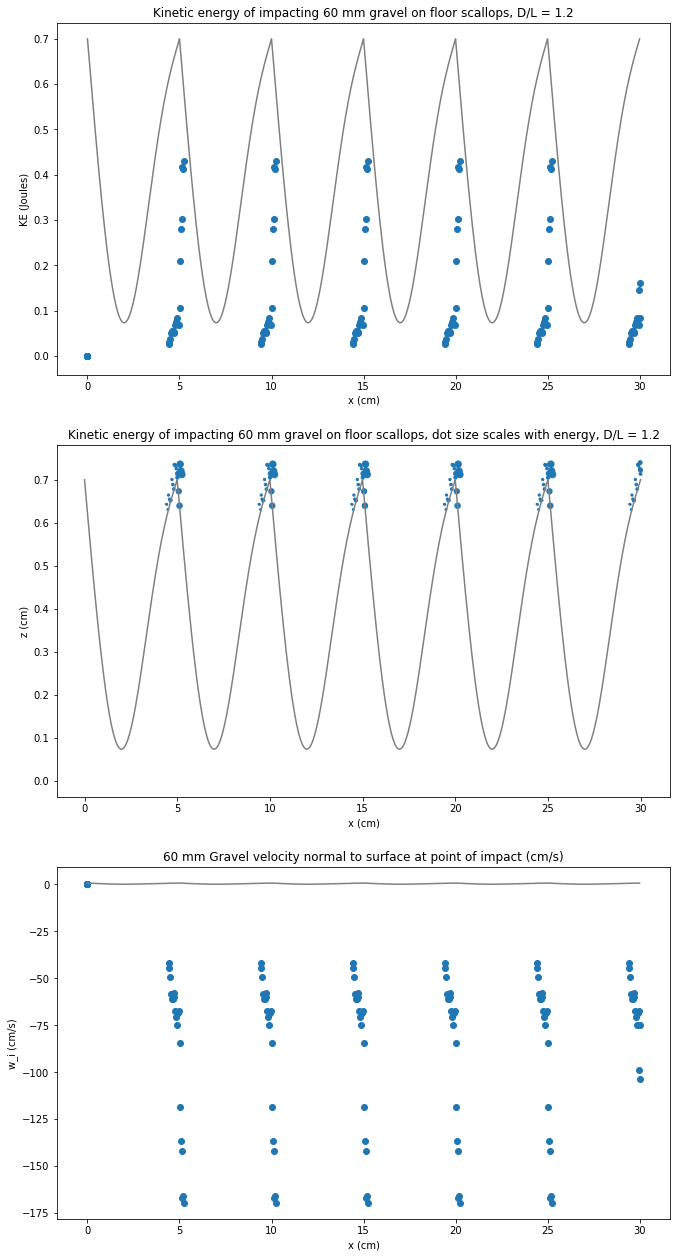

In [31]:
gravel_impact_data = sediment_saltation(x0, z0, Hf_gravel, w_water, u_water, u_w0, w_s_gravel, D_gravel, 0.05, theta2, drag_coef)

fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (11,22))    
#axs[0].set_xlim(10, 25)
axs[0].plot (x0, z0, 'grey')
axs[0].scatter (gravel_impact_data[:, 1], gravel_impact_data[:, 6]*10**-7)
axs[0].set_ylabel('KE (Joules)')
axs[0].set_xlabel('x (cm)')
axs[0].set_title('Kinetic energy of impacting 60 mm gravel on floor scallops, D/L = 1.2')
#axs[1].set_xlim(10, 25)
axs[1].plot (x0, z0, 'grey')
axs[1].scatter(gravel_impact_data[:, 1], gravel_impact_data[:, 2], (gravel_impact_data[:, 6])/10**5)
axs[1].set_ylabel('z (cm)')
axs[1].set_xlabel('x (cm)')
axs[1].set_title('Kinetic energy of impacting 60 mm gravel on floor scallops, dot size scales with energy, D/L = 1.2')
#axs[2].set_xlim(10, 25)
axs[2].plot (x0, z0, 'grey')
axs[2].scatter (gravel_impact_data[:, 1], gravel_impact_data[:, 5])
axs[2].set_title ('60 mm Gravel velocity normal to surface at point of impact (cm/s)')
axs[2].set_xlabel ('x (cm)')
axs[2].set_ylabel ('w_i (cm/s)');
